# **DENOISING DIFFUSION PROBABILISTIC MODEL (DDPM)**
## **TUTORIAL FOR BEGINNERS**

---------------------------------------------------------------------

### **LEARNING OUTCOMES**

* **Understand the core concepts of Diffusion Models (DDPM), including forward diffusion and reverse denoising.**
* **Set up a PyTorch environment with CUDA to leverage GPU acceleration.**
* **Load and preprocess image data using the CIFAR-10 dataset and visualize samples.**
* **Implement the forward diffusion process, adding noise to images over time using a defined noise schedule.**
* **Build a simplified U-Net neural network to predict noise in images at different timesteps.**
* **Train the model to learn the reverse diffusion process and reconstruct clean images from noisy ones.**
* **Sample new images from pure noise by reversing the diffusion steps with a trained model.**
* **Visualize intermediate steps of denoising, observing how noise is gradually removed to form meaningful images.**

#### **CUDA AND PYTORCH INSTALLATION**

First, a chech CUDA supported GPU has to be done (if you have a GPU). You can do that in https://developer.nvidia.com/cuda-gpus

And you can install CUDA from here: https://developer.nvidia.com/cuda-downloads

In [1]:
# Pytorch Installation
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
# Check the installation
import torch
print(torch.cuda.is_available()) # should print true if its available
print(torch.cuda.get_device_name(0)) # should print the GPU name

True
NVIDIA GeForce RTX 4070 Laptop GPU


After ensuring that it got installed, we're going to start building the model.

### **STEP 1: IMPORTING THE LIBRARIES THAT WE NEED**

All necessary libraries are imported for the project which includes PyTorch and torchvision for datasets and transformations and matplotlib for plotting and standard modules for neural network training and neural networks.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.utils import make_grid

### **STEP 2: LOADING AND VISUALIZING CIFAR-10 DATASET**

The CIFAR-10 dataset is loaded in this step through **torchvision.datasets**. The normalization process begins before visualization of sample images allows us to experience the data set. **ToTensor()** converts PIL images to tensors. **Normalize()** scales the pixel values to [-1, 1]. Then, we visualize a batch of images.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

batch_size = 128
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# visualize some images
def show_images(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.figure(figsize=(8,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# sample visualization
dataiter = iter(train_loader)
images, labels = next(dataiter)
show_images(make_grid(images[:16], nrow=4))


### **STEP 3: DEFINING THE PROCESSES IN DDPM**

Denoising Diffusion Probabilistic Models (DDPMs) have two processes:
* **Forward Diffusion**: It builds up noise throughout the process of image modification.
* **Reverse Process**: The neural network process gradually restores the original image by eliminating noise from it.

In [5]:
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    alphas_cumprod_t = alphas_cumprod[t].to(x_start.device)
    sqrt_alpha_cumprod = alphas_cumprod_t.sqrt().reshape(-1, 1, 1, 1)
    sqrt_one_minus_alpha_cumprod = (1 - alphas_cumprod_t).sqrt().reshape(-1, 1, 1, 1)
    return sqrt_alpha_cumprod * x_start + sqrt_one_minus_alpha_cumprod * noise

Setting the diffusion schedule with linearly spaced betas

In [6]:
T = 1000
betas = torch.linspace(1e-4, 0.02, T).cuda()
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

### **STEP 4: BUILDING THE DENOISING NEURAL NETWORK**

We will define a simple U-Net-style model to predict the noise at each timestep

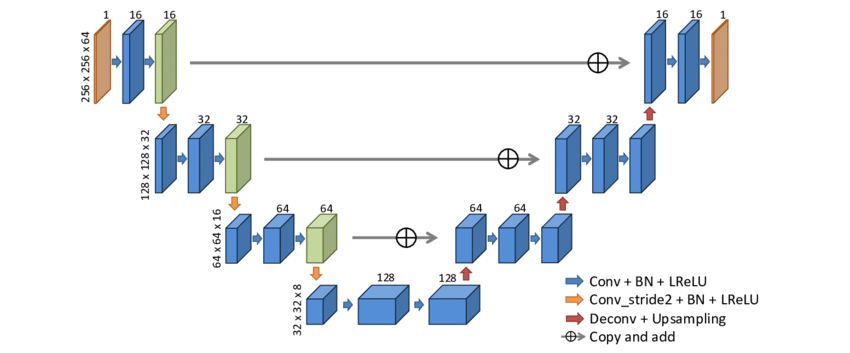

* **Down**: Two convolutional layers with ReLU followed by max pooling.
* **Middle**: One convolutional layer.
* **Up**: Transpose convolution for upsampling and output layer.

This U-Net takes a noisy image and a timestep t and predicts the noise added at that timestep.

In [7]:
def get_timestep_embedding(timesteps, dim):
    half_dim = dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)
    emb = timesteps[:, None].float() * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    return emb  

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, use_residual=True):
        super().__init__()
        self.use_residual = use_residual and in_channels == out_channels

        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, out_channels)
        )

        self.block1 = nn.Sequential(
            nn.GroupNorm(1, in_channels),  # Instead of 8 groups
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, 3, padding=1)
        )


        self.block2 = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )

    def forward(self, x, t_emb):
        h = self.block1(x)
        time_emb = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = h + time_emb
        h = self.block2(h)
        return x + h if self.use_residual else h

class DDPM_UNet(nn.Module):
    def __init__(self, time_emb_dim=256, in_channels=3, base_channels=64):
        super().__init__()

        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        self.conv1 = ResidualBlock(in_channels, base_channels, time_emb_dim)
        self.down1 = ResidualBlock(base_channels, base_channels * 2, time_emb_dim)
        self.downsample1 = nn.Conv2d(base_channels * 2, base_channels * 2, 4, 2, 1)

        self.down2 = ResidualBlock(base_channels * 2, base_channels * 4, time_emb_dim)
        self.downsample2 = nn.Conv2d(base_channels * 4, base_channels * 4, 4, 2, 1)

        self.middle = ResidualBlock(base_channels * 4, base_channels * 4, time_emb_dim)

        self.upsample2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 4, 4, 2, 1)
        self.up2 = ResidualBlock(base_channels * 4 + base_channels * 4, base_channels * 2, time_emb_dim)

        self.upsample1 = nn.ConvTranspose2d(base_channels * 2, base_channels * 2, 4, 2, 1)
        self.up1 = ResidualBlock(base_channels * 2 + base_channels * 2, base_channels, time_emb_dim)

        self.final = nn.Sequential(
            nn.GroupNorm(8, base_channels),
            nn.SiLU(),
            nn.Conv2d(base_channels, in_channels, 3, padding=1)
        )

    def forward(self, x, t):
        t_emb = get_timestep_embedding(t, self.time_mlp[0].in_features)
        t_emb = self.time_mlp(t_emb)
        x1 = self.conv1(x, t_emb)
        x2 = self.down1(x1, t_emb)
        x3 = self.downsample1(x2)
        x4 = self.down2(x3, t_emb)
        x5 = self.downsample2(x4)
        x_mid = self.middle(x5, t_emb)
        x = self.upsample2(x_mid)
        x = self.up2(torch.cat([x, x4], dim=1), t_emb)
        x = self.upsample1(x)
        x = self.up1(torch.cat([x, x2], dim=1), t_emb)
        return self.final(x)

In [8]:
def loss_fn(model, x_0, t):
    noise = torch.randn_like(x_0)
    x_noisy = q_sample(x_0, t, noise)
    noise_pred = model(x_noisy, t)
    return F.mse_loss(noise_pred, noise)

### **STEP 5: TRAINING SETUP**

We use the **Adam optimizer** and **MSE** loss to train the network.

During training:
* For each image, we sample a timestep **t**
* Add noise to the image using the forward diffusion process
* Predict the noise using the model
* Compute the loss between predicted and actual noise

In [ ]:
model = DDPM_UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 100
model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    for x_0, _ in train_loader:
        x_0 = x_0.to(device)
        t = torch.randint(0, T, (x_0.size(0),), device=device).long()
        noise = torch.randn_like(x_0)
        x_noisy = q_sample(x_0, t, noise)
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] | Avg Loss: {avg_loss:.6f}")

Epoch [1/100] | Avg Loss: 0.248124
Epoch [2/100] | Avg Loss: 0.136299
Epoch [3/100] | Avg Loss: 0.110326
Epoch [4/100] | Avg Loss: 0.092387
Epoch [5/100] | Avg Loss: 0.079975
Epoch [6/100] | Avg Loss: 0.068779
Epoch [7/100] | Avg Loss: 0.061535
Epoch [8/100] | Avg Loss: 0.054485
Epoch [9/100] | Avg Loss: 0.050645
Epoch [10/100] | Avg Loss: 0.046484
Epoch [11/100] | Avg Loss: 0.043806
Epoch [12/100] | Avg Loss: 0.042106
Epoch [13/100] | Avg Loss: 0.040484
Epoch [14/100] | Avg Loss: 0.039375


### **STEP 6: GENERATING IMAGES FROM NOISE**

Once the model is trained, we can generate new images from pure noise by reversing the diffusion process.

In [ ]:
@torch.no_grad()
def sample_image(model, img_size=(1,3,32,32), steps=T):
    model.eval()
    x = torch.randn(img_size).cuda()
    intermediate_images = []

    for t in reversed(range(steps)):
        t_batch = torch.full((img_size[0],), t, device='cuda', dtype=torch.long)
        beta = betas[t]
        alpha = alphas[t]
        alpha_bar = alphas_cumprod[t]
        predicted_noise = model(x, t_batch)
        coef_x0 = 1 / torch.sqrt(alpha)
        coef_noise = (1 - alpha) / torch.sqrt(1 - alpha_bar)
        if t > 0:
            noise = torch.randn_like(x).cuda()
        else:
            noise = torch.zeros_like(x).cuda()
        x = coef_x0 * (x - coef_noise * predicted_noise) + torch.sqrt(beta) * noise
        intermediate_images.append(x.cpu().detach().clone())
    return intermediate_images

We iterate from timestep **T-1** to **0**, progressively denoising the image using our trained model. Intermediate images are saved at each step for visualization.

### **STEP 7: VISUALISING DENOISING STEPS**

To see how the image gradually forms from noise, we plot a few intermediate steps.

In [ ]:
generated_images = sample_image(model, (1,3,32,32))
fig, axes = plt.subplots(1, 10, figsize=(20,2))
interval = len(generated_images) // 10

for i, ax in enumerate(axes):
    img = generated_images[i * interval][0]
    img = (img.clamp(-1, 1) + 1) / 2  
    np_img = img.permute(1,2,0).numpy()
    ax.imshow(np_img)
    ax.set_title(f'Step {T - (i * interval)}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Every 100 timesteps (10 total samples), we show the state of the image, illustrating the reverse process in action.

### **STEP 8: FINAL VISUALISATION**

Finally, we display the fully generated image after all timesteps

In [ ]:
final_img = generated_images[-1][0].detach()
final_img = (final_img.clamp(-1, 1) + 1) / 2
plt.imshow(np.transpose(final_img.numpy(), (1,2,0)))
plt.title("Generated Image")
plt.axis('off')
plt.show()

# **SUMMARY**

* **Forward Diffusion (q_sample)**: Images are progressively noised over **T** timesteps using a beta schedule **(alphas_cumprod)**, simulating the diffusion process.
* **U-Net Denoising Model (DDPM_UNet)**: A deep residual U-Net with skip connections, GroupNorm, and sinusoidal time embeddings to condition the model on each timestep.
* **Training Objective**: The model is trained to predict the added noise using MSE loss.
* **Successful Training Loop**: With proper time conditioning and normalization, the model learns to denoise effectively, and the loss steadily decreases.
* **Ready for Sampling & Extensions**: The setup is now ready for generating images **(p_sample_loop)**, adding EMA, saving checkpoints, or visualizing denoising steps.